# Пакетное решение

4.500000000000001 4.500533333333333


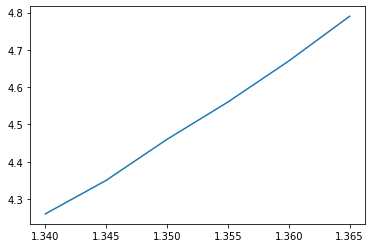

In [ ]:
X = [1.340, 1.345, 1.350, 1.355, 1.360, 1.365]
Y = [4.26, 4.35, 4.46, 4.56, 4.67, 4.79]

X_1 = 1.352

import matplotlib.pyplot as plt
plt.plot(X, Y)

from scipy.interpolate import interp1d

f1 = interp1d(X, Y,kind = 'linear')
f2 = interp1d(X, Y, kind = 'cubic')

print(f1(X_1), f2(X_1))

# Многочлен Ньютона

In [ ]:
def coef(x, y):
  '''x : list of data points
      y : list of f(x)  '''

  n = len(x)
  a = y

  for j in range(1, n):
      for i in range(n-1, j-1, -1):
          a[i] = float(a[i]-a[i-1])/float(x[i]-x[i-j])
  
  return a # return an array of coefficient

def Eval(a, x, r):

  ''' a : list returned by function coef()
    x : list of data points
    r : the node to interpolate at  '''
    
  n = len( a ) - 1
  temp = a[n] + (r - x[n])
  for i in range( n - 1, -1, -1 ):
      temp = temp * (r - x[i]) + a[i]
  return temp # return the y_value interpolation


print(Eval(coef(X, Y), X, X_1))

4.500447359999948


# Многочлен Лагранжа

In [ ]:
def lagrang(X, Y, X_1):
  rang = len(X)
  summa = 0
  for i in range(rang):
    mult_1, mult_2 = 1, 1
    for k in range(rang - 1):
      if k != i:
        mult_1 = mult_1*(X_1 - X[k])
        mult_2 = mult_2*(X[i] - X[k])
      else:
        pass
    summa = summa + Y[i]*mult_1/mult_2 
  return summa

lagrang(X, Y, X_1)

4.55270208

# Интерполирование сплайнами

In [ ]:
# Структура, описывающая сплайн на каждом сегменте сетки
class SplineTuple:
    def __init__(self, a, b, c, d, x):
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        self.x = x
 
# Построение сплайна
# x - узлы сетки, должны быть упорядочены по возрастанию, кратные узлы запрещены
# y - значения функции в узлах сетки
# n - количество узлов сетки
def BuildSpline(x, y, n):
    # Инициализация массива сплайнов
    splines = [SplineTuple(0, 0, 0, 0, 0) for _ in range(0, n)]
    for i in range(0, n):
        splines[i].x = x[i]
        splines[i].a = y[i]
    
    splines[0].c = splines[n - 1].c = 0.0
    
    # Решение СЛАУ относительно коэффициентов сплайнов c[i] методом прогонки для трехдиагональных матриц
    # Вычисление прогоночных коэффициентов - прямой ход метода прогонки
    alpha = [0.0 for _ in range(0, n - 1)]
    beta  = [0.0 for _ in range(0, n - 1)]
 
    for i in range(1, n - 1):
        hi  = x[i] - x[i - 1]
        hi1 = x[i + 1] - x[i]
        A = hi
        C = 2.0 * (hi + hi1)
        B = hi1
        F = 6.0 * ((y[i + 1] - y[i]) / hi1 - (y[i] - y[i - 1]) / hi)
        z = (A * alpha[i - 1] + C)
        alpha[i] = -B / z
        beta[i] = (F - A * beta[i - 1]) / z
  
 
    # Нахождение решения - обратный ход метода прогонки
    for i in range(n - 2, 0, -1):
        splines[i].c = alpha[i] * splines[i + 1].c + beta[i]
    
    # По известным коэффициентам c[i] находим значения b[i] и d[i]
    for i in range(n - 1, 0, -1):
        hi = x[i] - x[i - 1]
        splines[i].d = (splines[i].c - splines[i - 1].c) / hi
        splines[i].b = hi * (2.0 * splines[i].c + splines[i - 1].c) / 6.0 + (y[i] - y[i - 1]) / hi
    return splines
 
 
# Вычисление значения интерполированной функции в произвольной точке
def Interpolate(splines, x):
    if not splines:
        return None # Если сплайны ещё не построены - возвращаем NaN
    
    n = len(splines)
    s = SplineTuple(0, 0, 0, 0, 0)
    
    if x <= splines[0].x: # Если x меньше точки сетки x[0] - пользуемся первым эл-тов массива
        s = splines[0]
    elif x >= splines[n - 1].x: # Если x больше точки сетки x[n - 1] - пользуемся последним эл-том массива
        s = splines[n - 1]
    else: # Иначе x лежит между граничными точками сетки - производим бинарный поиск нужного эл-та массива
        i = 0
        j = n - 1
        while i + 1 < j:
            k = i + (j - i) // 2
            if x <= splines[k].x:
                j = k
            else:
                i = k
        s = splines[j]
    
    dx = x - s.x
    # Вычисляем значение сплайна в заданной точке по схеме Горнера (в принципе, "умный" компилятор применил бы схему Горнера сам, но ведь не все так умны, как кажутся)
    return s.a + (s.b + (s.c / 2.0 + s.d * dx / 6.0) * dx) * dx;
    
spline = BuildSpline(X, Y, 6)
print(Interpolate(spline, X_1))

NameError: ignored